In [232]:
import pandas as pd


In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp
from sklearn.utils import shuffle
from sklearn.feature_selection import VarianceThreshold,mutual_info_regression ,mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,plot_confusion_matrix,r2_score,mean_squared_error
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [234]:
ds = pd.read_csv('/content/Churn.csv')


In [235]:
ds = ds.drop('customerID',axis=1)
ds.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Feature engineering

## Data cleaning including missing values, outliers and multicolinearity


In [236]:
ds.TotalCharges = pd.to_numeric(ds.TotalCharges, errors='coerce')

ds.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [237]:
ds.TotalCharges =ds.TotalCharges.fillna(ds.TotalCharges.mean())

In [238]:
# finding and  fixing skewness 

numeric_features = list(ds.dtypes[(ds.dtypes != "str") & (ds.dtypes !='object')].index)


numeric_features.remove('SeniorCitizen')

#numeric_features.remove('tenure')

skewed_features = ds[numeric_features].apply(lambda x : skew (x)).sort_values(ascending=False)



skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    ds[feat], l_opt[feat] = boxcox((ds[feat]+1))

skewed_features2 = ds[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 1 higest skewed numerical features to box cox transform


,Skew,New Skew
TotalCharges,0.962189,-0.144868


In [239]:
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features

In [240]:
cont_features, cat_features = divideFeatures(ds)
cat_features

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,No
7039,Female,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),No
7040,Female,Yes,Yes,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
7041,Male,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,Yes


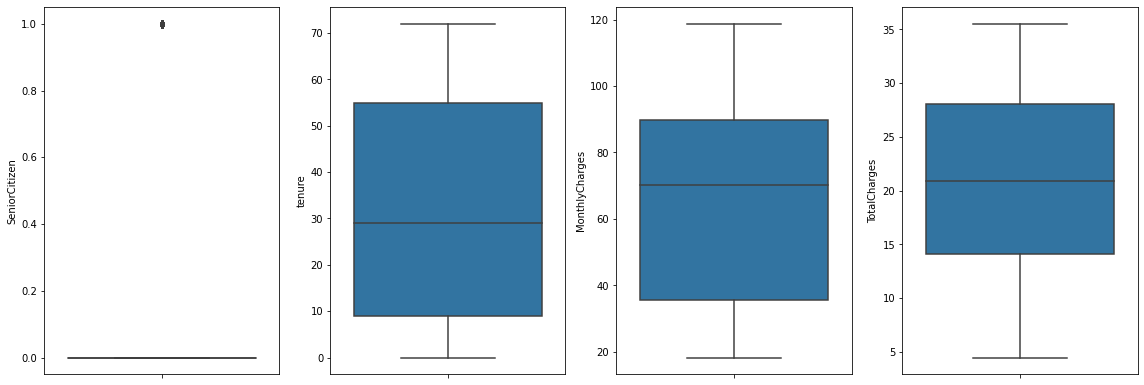

In [241]:
# boxplots of numerical features for outlier detection

fig = plt.figure(figsize=(16,16))
for i in range(len(cont_features.columns)):
    fig.add_subplot(3, 4, i+1)
    sns.boxplot(y=cont_features.iloc[:,i])
plt.tight_layout()
plt.show()


There are not much outliers in data set 

In [242]:
ds.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [243]:
corr_df = pd.get_dummies(ds[['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'Churn']]).corr()


corr_yes_churn = corr_df['Churn_Yes'].sort_values().iloc[1:-1]
corr_yes_churn

Contract_Two year                         -0.302253
StreamingMovies_No internet service       -0.227890
StreamingTV_No internet service           -0.227890
TechSupport_No internet service           -0.227890
DeviceProtection_No internet service      -0.227890
OnlineBackup_No internet service          -0.227890
OnlineSecurity_No internet service        -0.227890
InternetService_No                        -0.227890
PaperlessBilling_No                       -0.191825
Contract_One year                         -0.177820
OnlineSecurity_Yes                        -0.171226
TechSupport_Yes                           -0.164674
Dependents_Yes                            -0.164221
Partner_Yes                               -0.150448
PaymentMethod_Credit card (automatic)     -0.134302
InternetService_DSL                       -0.124214
PaymentMethod_Bank transfer (automatic)   -0.117937
PaymentMethod_Mailed check                -0.091683
OnlineBackup_Yes                          -0.082255
DeviceProtec

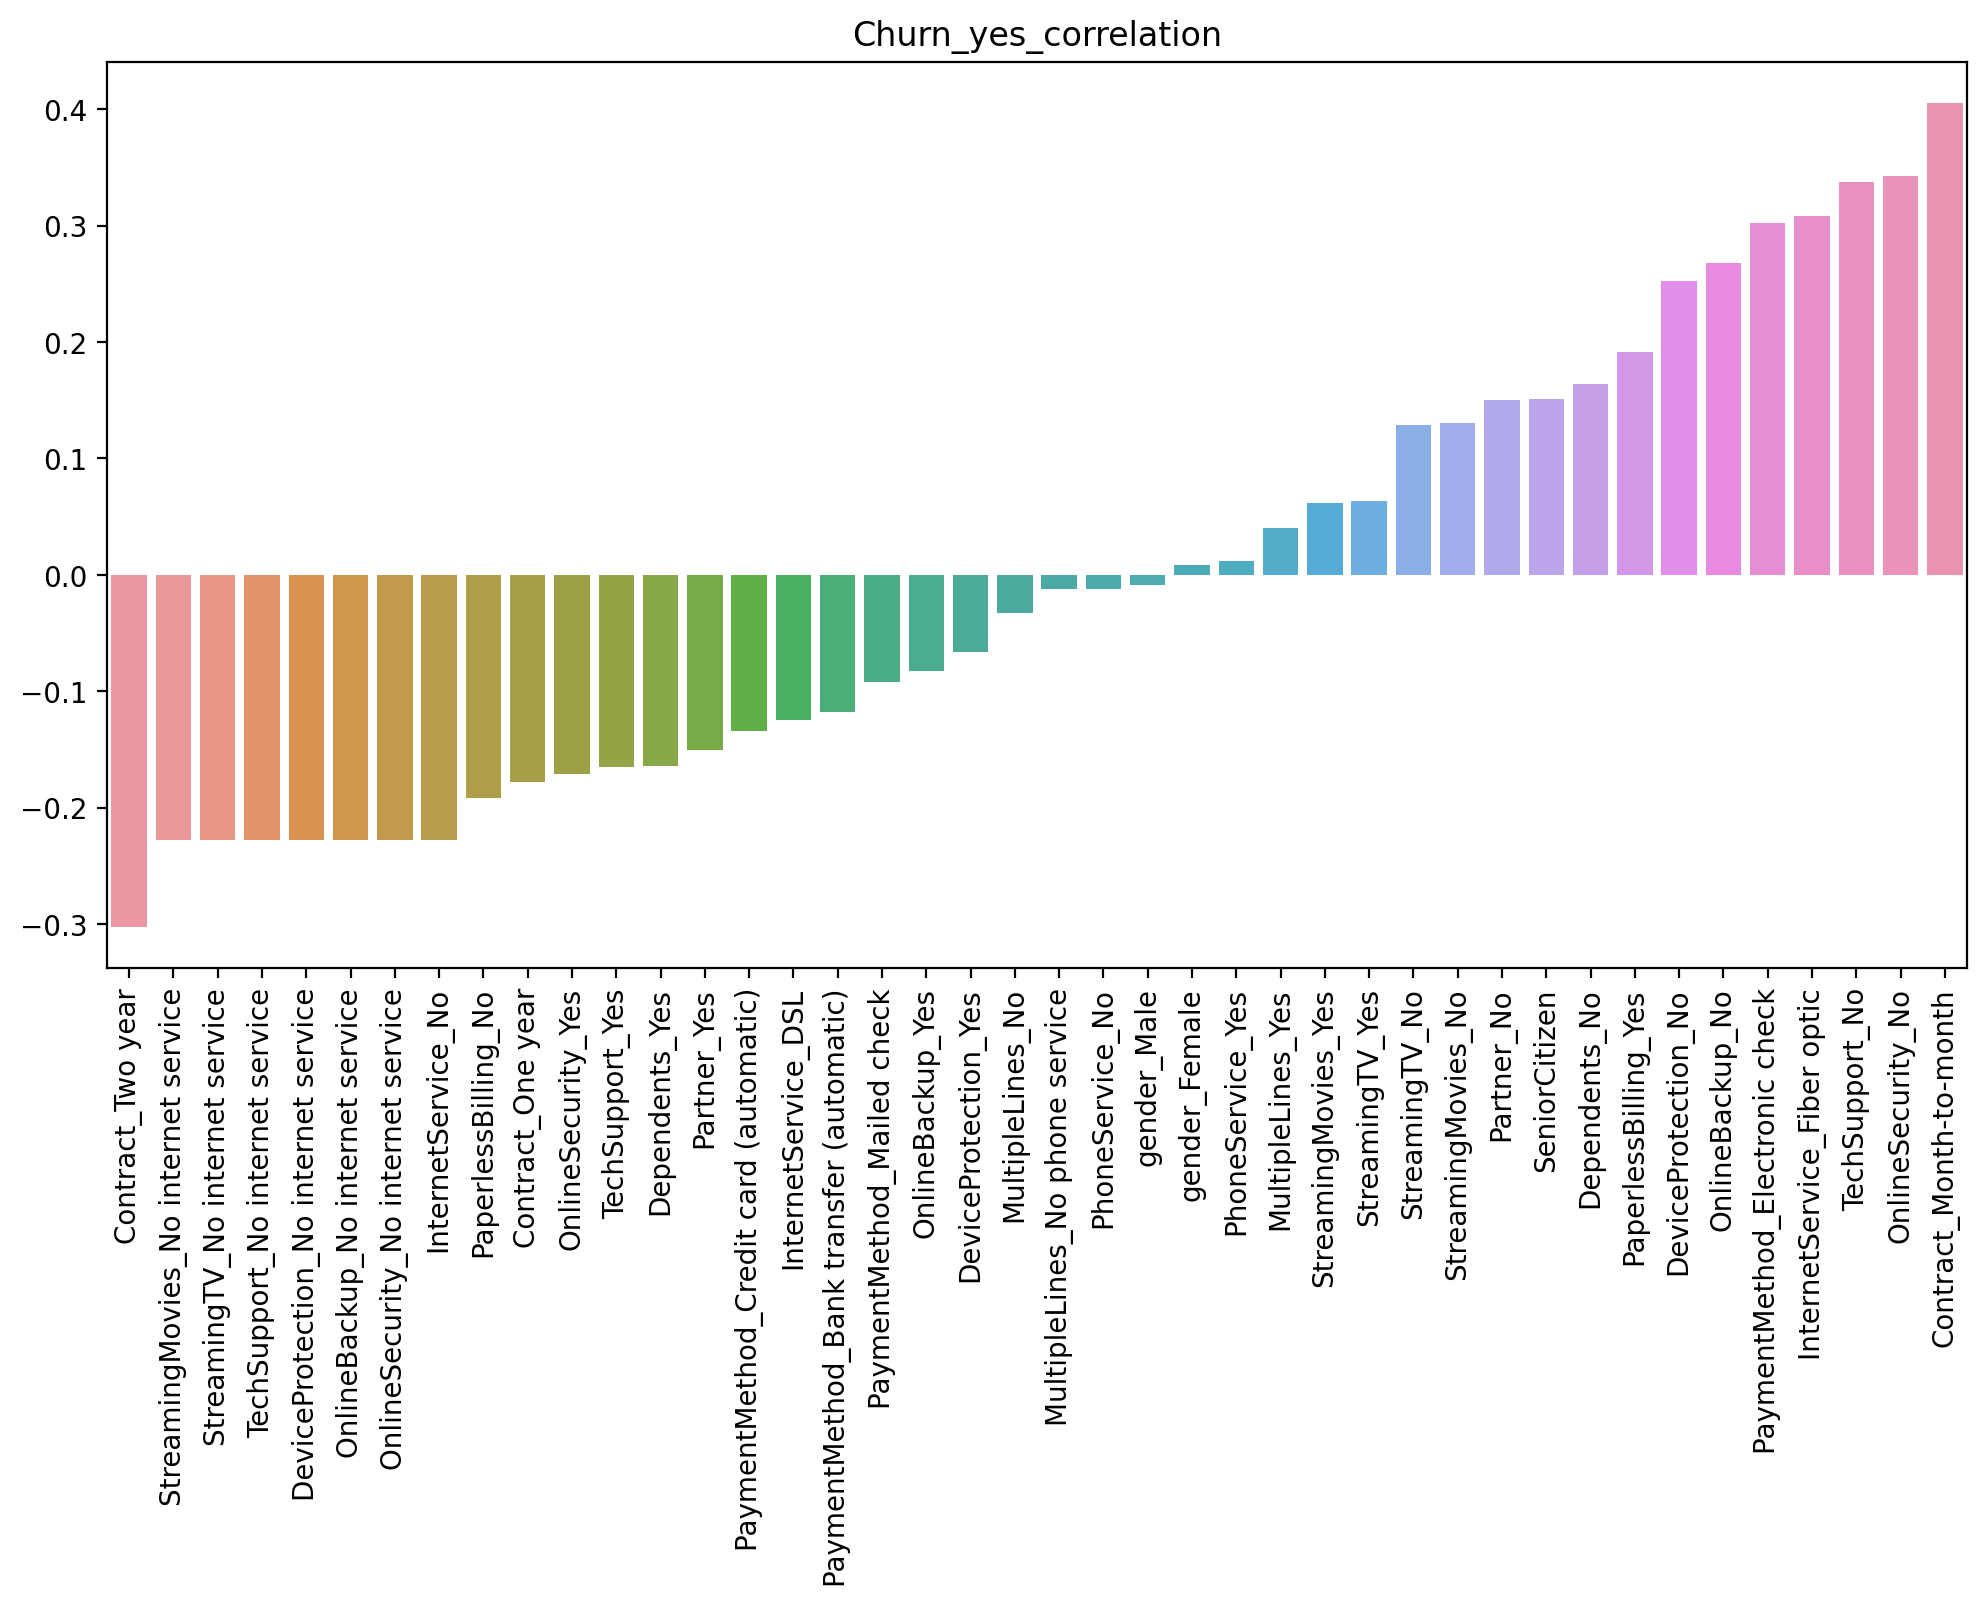

In [244]:
plt.figure(figsize=(12,6),dpi=200)
plt.title('Churn_yes_correlation')
sns.barplot(x=corr_yes_churn.index,y=corr_yes_churn.values)
plt.xticks(rotation=90);

clearly we can see that month_to_month contract Churning more than Year contract

gender,phone_service and multiple lines doesn't having any impact on churning and not churning

In [245]:
from sklearn.preprocessing import LabelEncoder , StandardScaler

In [246]:
le = LabelEncoder()

In [247]:
cat_features = pd.get_dummies(cat_features,drop_first=True)
cat_features

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,1,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,0,0,1,0
7039,0,1,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,1,0,0,0
7040,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
7041,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1


In [248]:
ds = pd.concat([cat_features,cont_features],axis=1)
ds.TotalCharges = ds.TotalCharges.fillna(0)
ds.head()

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,29.85,5.472207
1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,34,56.95,22.845051
2,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,2,53.85,9.035483
3,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,45,42.30,22.667781
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,2,70.70,10.189949


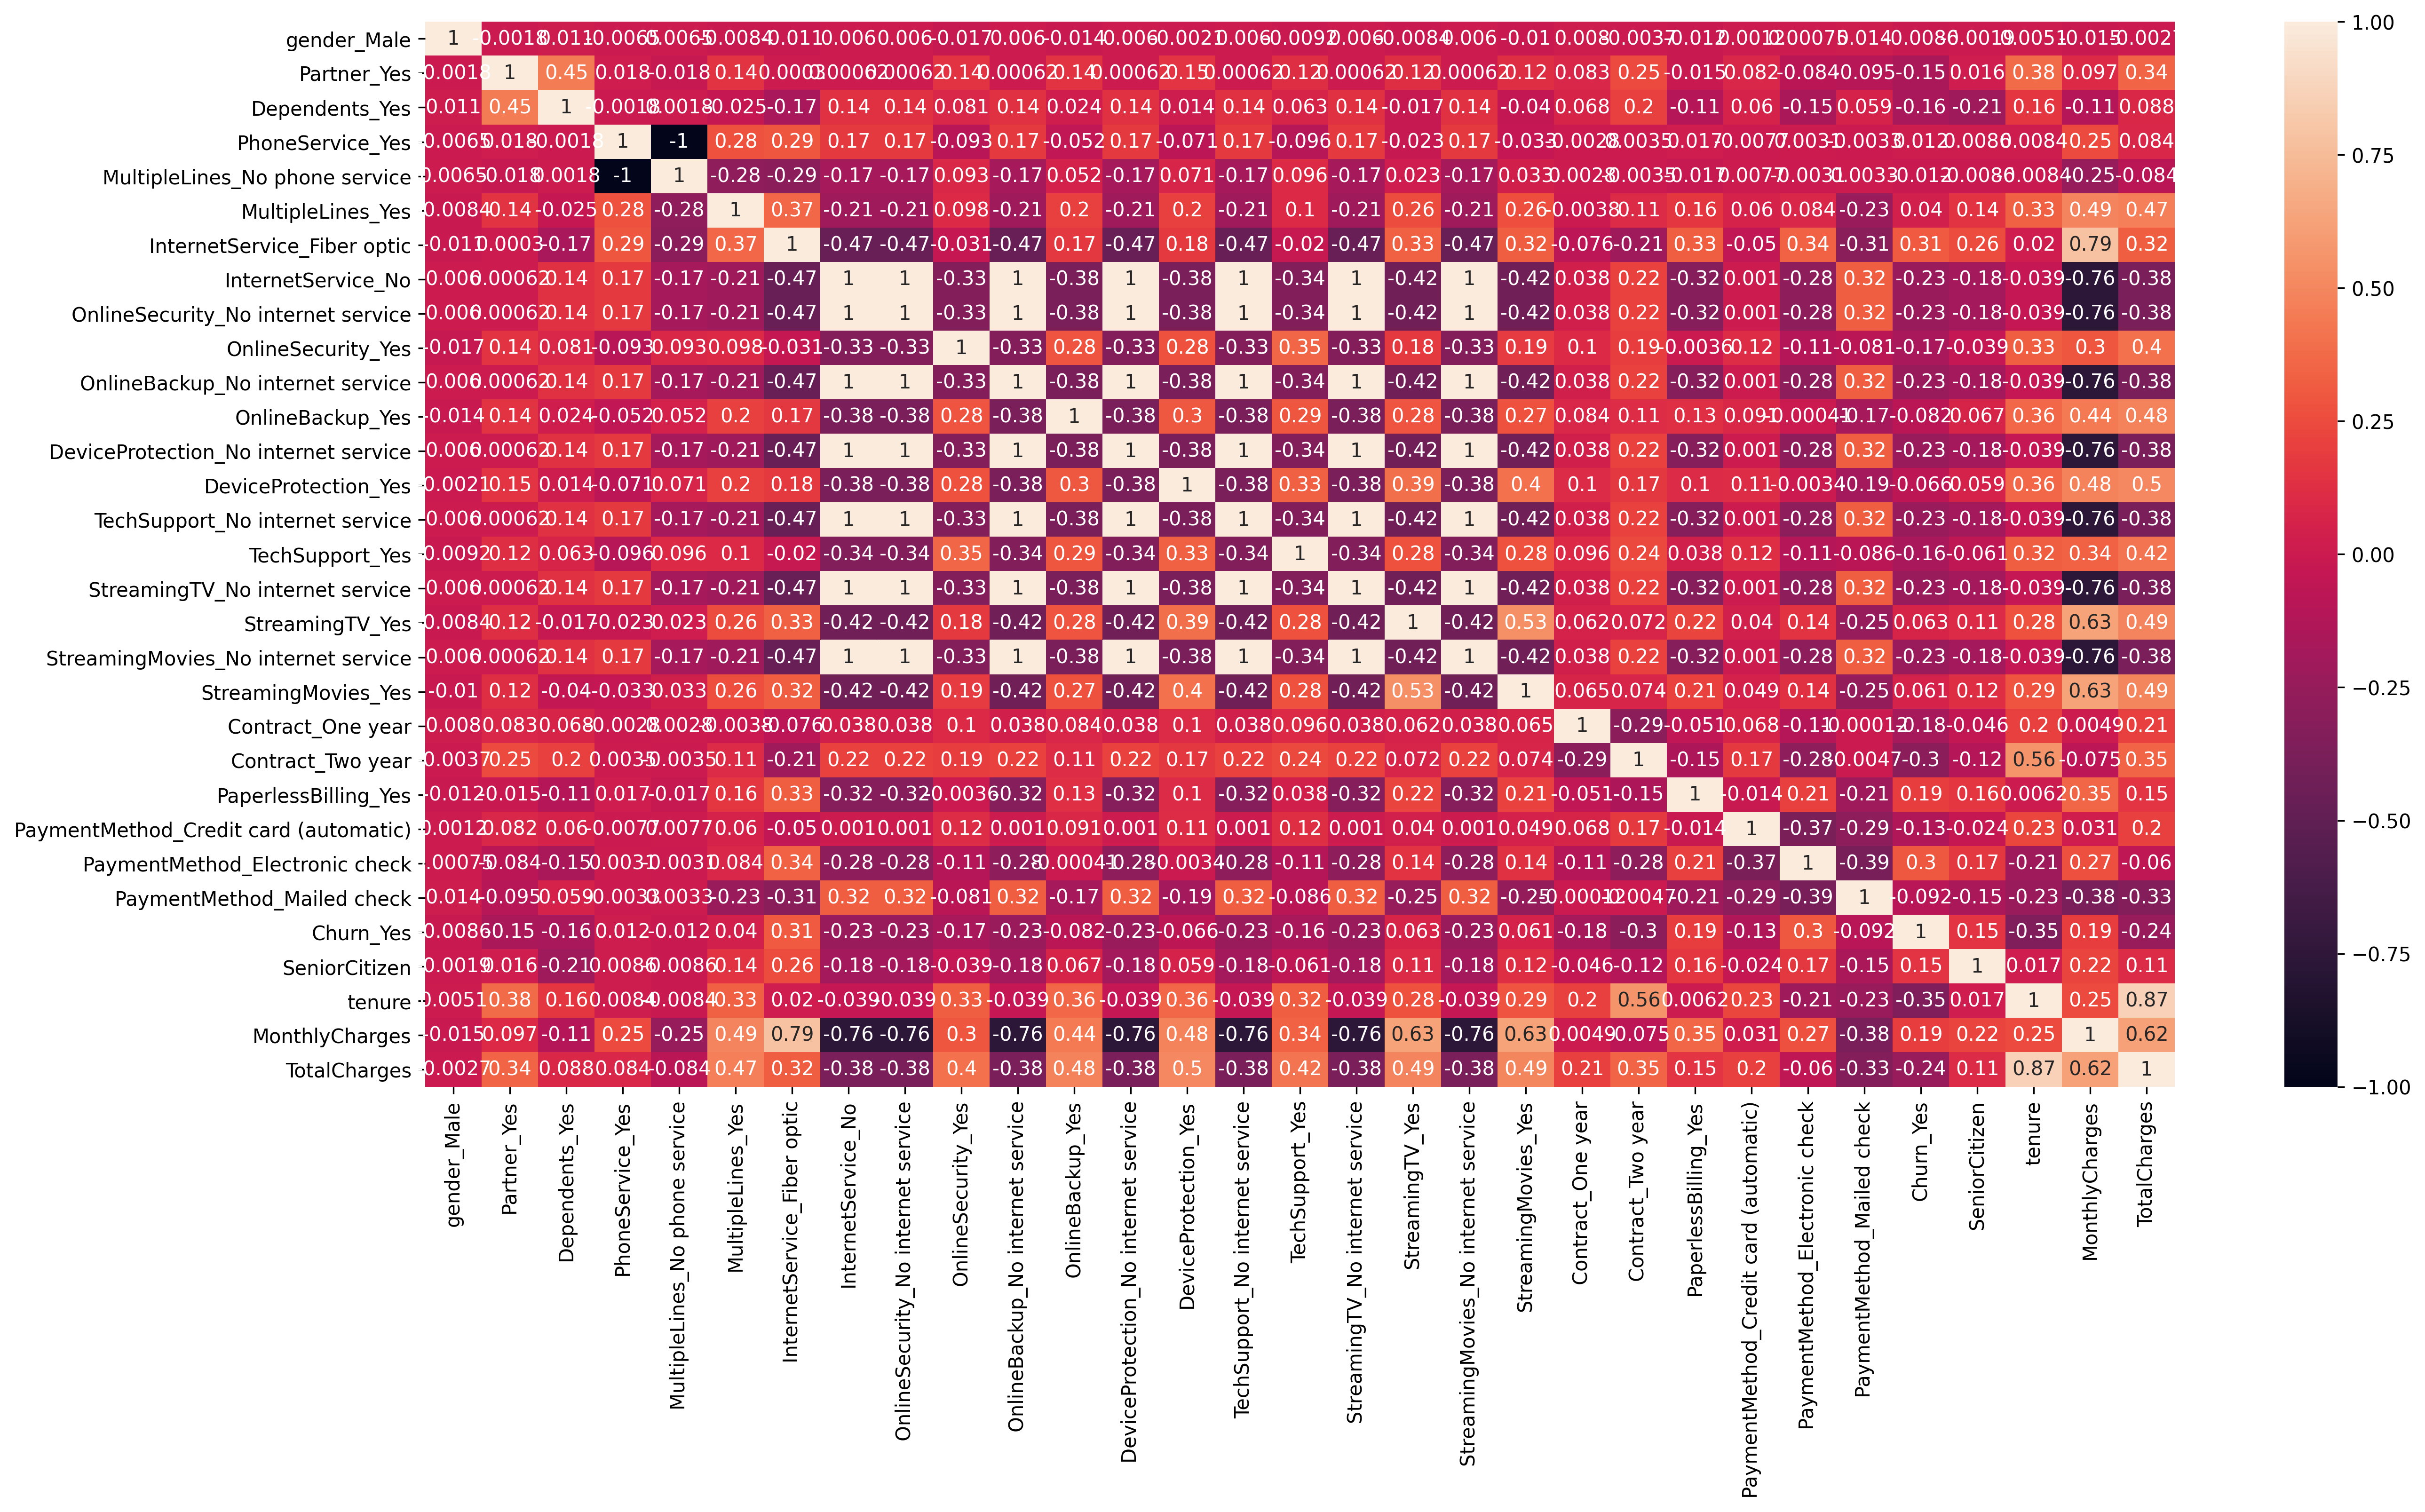

In [249]:
plt.figure(figsize=(20,10),dpi=300)
sns.heatmap(ds.corr(),annot=True)

 we can check multi colinearity usin heatmap easily 
 
 you can see that totalcharge and tenure having strong multicollinearity

In [250]:

X = ds.drop('Churn_Yes',axis=1)
y = ds.Churn_Yes


In [251]:

from sklearn.model_selection import train_test_split,RandomizedSearchCV
X_train,X_test,y_train,y_test = train_test_split(X,y ,test_size=0.1,random_state=42)

In [252]:
feat = VarianceThreshold()
feat.fit(X_train)
X_train.columns[feat.get_support()]

Index(['gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

## Feature Selection

## How did you select variables to be included in the model?

In [253]:

mutual_info = mutual_info_classif(X_train,y_train)
mutual_info

array([0.00285746, 0.0184319 , 0.01769746, 0.        , 0.00661475,
       0.00717773, 0.05586406, 0.0232417 , 0.02922056, 0.01274965,
       0.02911153, 0.00479278, 0.02086739, 0.        , 0.02131214,
       0.01950693, 0.02957143, 0.        , 0.03097868, 0.00637971,
       0.01896334, 0.05677412, 0.01626233, 0.00250125, 0.04730146,
       0.        , 0.00767261, 0.06805177, 0.05127307, 0.04232595])

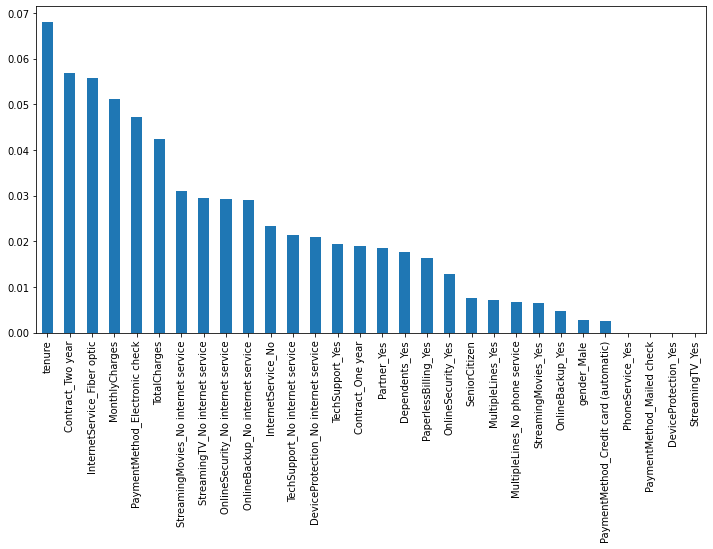

In [254]:
feature_imp = pd.Series(mutual_info)
feature_imp.index = X_train.columns
feature_imp.sort_values(ascending=False).plot.bar(figsize=(12,6))

Mutual information (MI)  between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

gender and multiplelines having less impact on target variable 
we can remove those two if we want 

## Modeling

In [255]:
randomforest = RandomForestClassifier()


In [256]:
randomforest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [257]:
param_grid ={'criterion' : ['gini', 'entropy'],'class_weight' : ['balanced', None],'n_estimators' : [150,175,200,220,250],
             'max_depth'  : [20, None, 3, 4, 5, 10,15] ,'min_samples_split' : [2, 3, 4],'min_samples_leaf' : [1 , 2 , 3] }


In [258]:
gs = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)


In [259]:
gs.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.0s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [260]:
gs.best_params_

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 175}

In [261]:
data =randomforest.feature_importances_

In [262]:
feat_imp = pd.DataFrame(index=X.columns,data=data,columns=['feature_importances'])
feat = feat_imp.sort_values('feature_importances')
feat

,feature_importances
DeviceProtection_No internet service,0.003293
MultipleLines_No phone service,0.003742
PhoneService_Yes,0.004181
InternetService_No,0.004227
OnlineBackup_No internet service,0.005169
StreamingTV_No internet service,0.005296
OnlineSecurity_No internet service,0.005606
StreamingMovies_No internet service,0.005674
TechSupport_No internet service,0.005899
PaymentMethod_Mailed check,0.012848


##Assuming these actions were implemented, how would you determine whether they had worked?

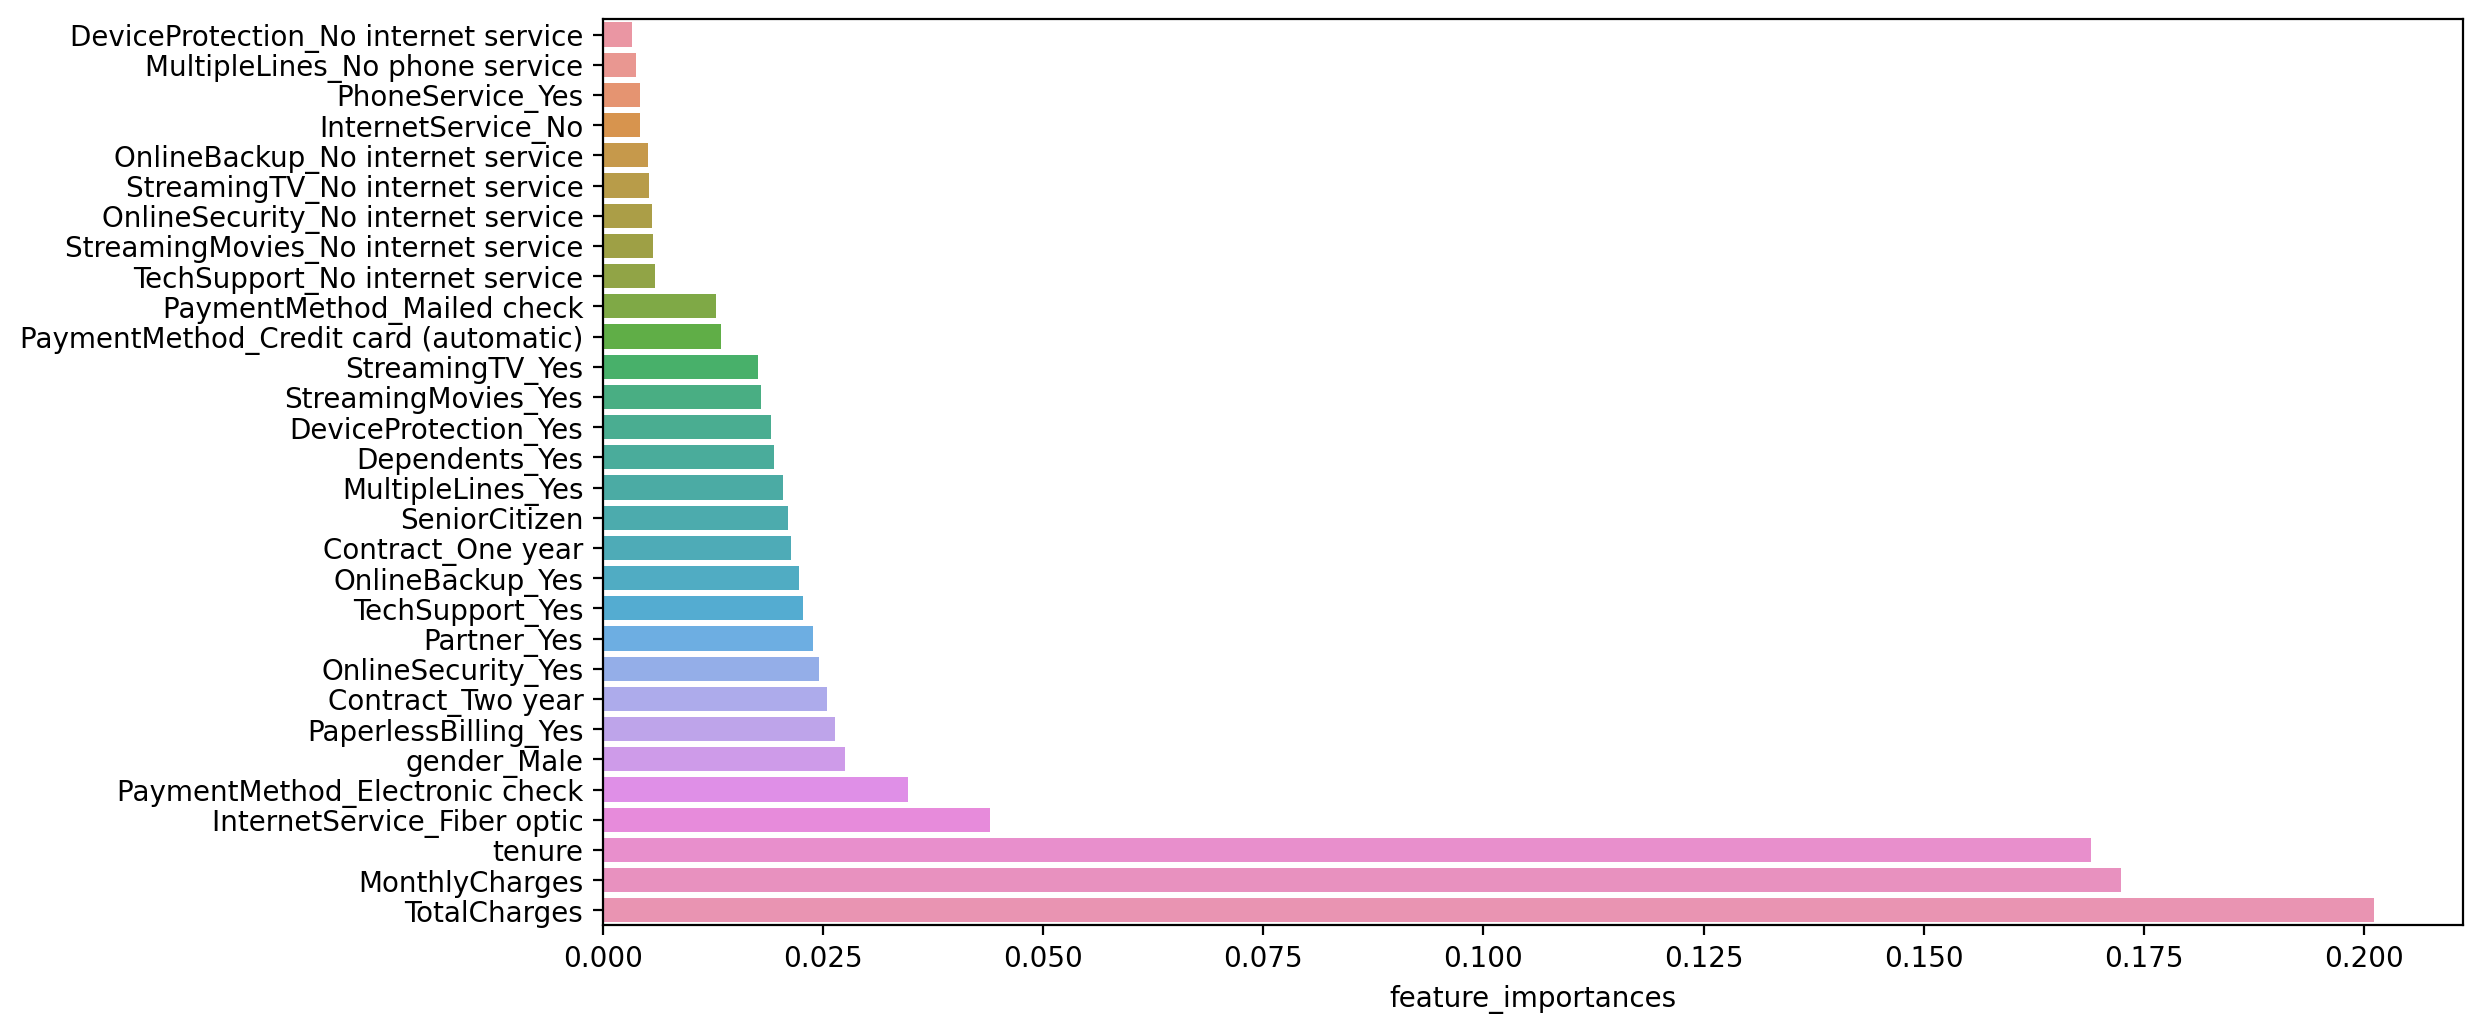

In [263]:
plt.figure(figsize=(12,6),dpi=200)
sns.barplot(y=feat.index,x=feat['feature_importances'])

 these  are the key factors that predict customer churn from bottom to top

most of customers churning are already subscibed(tenure) 

## performance of the model

In [264]:
y_pred = gs.predict(X_test)

In [265]:
accuracy_score(y_test,y_pred)

0.8099290780141843

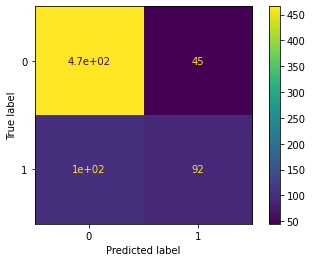

In [266]:
plot_confusion_matrix(randomforest,X_test,y_test)

totally 140 Miss classification occured 

What offers should be made to which customers to encourage them to remain with
c
ompany?

by providing tech support , online security , online backups, 

by providing yearly contract rather than montly contract